# ***Import usuals libraries***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


c:\Users\33760\anaconda3\envs\myenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ***Import and Discover data***

In [2]:
# Set the maximum number of displayed columns to 20
pd.set_option('display.max_column', 20)

In [3]:
# Import data
df_train = pd.read_csv(r'C:\Users\33760\Desktop\concours_kaggle\playground-series-s3e26\train.csv')

In [4]:
# Import data
df_test = pd.read_csv(r'C:\Users\33760\Desktop\concours_kaggle\playground-series-s3e26\test.csv')

In [5]:
# Create data copies 
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [7]:
from functions import drop_column

# Delete ID column
drop_column(df_train, 'id', df_name = 'df_train')

The 'id' column has been removed from df_train.


# ***Missing values***

In [8]:
missing_rate = (df_train.isna().sum()/df_train.shape[0]).sort_values(ascending = True)
missing_rate

N_Days           0.0
Prothrombin      0.0
Platelets        0.0
Tryglicerides    0.0
SGOT             0.0
Alk_Phos         0.0
Copper           0.0
Albumin          0.0
Stage            0.0
Cholesterol      0.0
Edema            0.0
Spiders          0.0
Hepatomegaly     0.0
Ascites          0.0
Sex              0.0
Age              0.0
Drug             0.0
Bilirubin        0.0
Status           0.0
dtype: float64

In [9]:
missing_rate = (df_test.isna().sum()/df_test.shape[0]).sort_values(ascending = True)
missing_rate

id               0.0
Platelets        0.0
Tryglicerides    0.0
SGOT             0.0
Alk_Phos         0.0
Copper           0.0
Albumin          0.0
Cholesterol      0.0
Prothrombin      0.0
Bilirubin        0.0
Spiders          0.0
Hepatomegaly     0.0
Ascites          0.0
Sex              0.0
Age              0.0
Drug             0.0
N_Days           0.0
Edema            0.0
Stage            0.0
dtype: float64

# ***Preprocessing***

### ***Manage Outliers / Underliers***

In [10]:
# Manage outliers with Winsorize method

def winsorize_outliers_dataframe(df, lower_percentile=0.05, upper_percentile=0.95):
    """
    Parameters:
    df (pd.DataFrame): The DataFrame to be processed.
    lower_percentile (float): The lower percentile from which winsorizing is applied.
    upper_percentile (float): The upper percentile from which winsorizing is applied.

    Returns:
    pd.DataFrame: The DataFrame with the winsorized outliers.
    """
    for column in df.columns:
        # Check if the columns is numeric
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate lower and upper limits based on percentiles
            lower_limit = df[column].quantile(lower_percentile)
            upper_limit = df[column].quantile(upper_percentile)
            # Replace values outside the specified percentile range with limits
            df[column] = np.where(df[column] < lower_limit, lower_limit, np.where(df[column] > upper_limit, upper_limit, df[column]))
    # return the modified Dataframe
    return df

In [11]:
# Manage outliers with standard deviation method

def remove_outliers_std_dataframe(df, threshold=3):
    """
    Removes outliers using the standard deviation for all columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to be processed.
    threshold (float): The number of standard deviations above which to remove outliers.

    Returns:
    pd.DataFrame: The DataFrame without the outliers.
    """
    # Apply outlier suppression to each column
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        mean_val = df[column].mean()
        std_val = df[column].std()

        # Calculate limits
        lower_limit = mean_val - threshold * std_val
        upper_limit = mean_val + threshold * std_val

        # Delete outliers / underliers
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

    return df


In [12]:
# Manage outliers with IQR method

def remove_outliers_iqr_inplace(df, multiplier=1.5):
    """
    Remove outliers using the Interquartile Range (IQR) method.

    Parameters:
    df (pd.DataFrame): The DataFrame to be processed (modified in place).
    multiplier (float): The multiplier factor to determine the IQR boundaries.
    """
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Calculate quantiles for each numeric column
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate IQR boundaries for each numeric column
    lower_limit = Q1 - multiplier * IQR
    upper_limit = Q3 + multiplier * IQR

    # Remove rows containing outliers
    df.drop(df[(df[numeric_columns] < lower_limit) | (df[numeric_columns] > upper_limit)].index, inplace=True) # Replace Value instead of cretae a new object 

In [13]:
# Apply Winsorize
df_train = remove_outliers_std_dataframe(df_train, threshold = 3) # the Winsorize method will be preferred (best results)

In [14]:
# df_train = remove_outliers_iqr_inplace(df_train, multiplier=1.5)

In [15]:
# df_train = winsorize_outliers_dataframe(df_train, lower_percentile=0.05, upper_percentile=0.95)

We can't use a Delete outliers / underliers method because we need to respect the 'sample_submission.csv' lenght.

### ***TrainTest - Cleaning - Encoding***

In [16]:
def Separate_target_features(df):

    # Separate target variable Y from features X
    print("Separating labels from features...")
    target_variable = "Status"

    X = df.drop(target_variable, axis = 1)
    Y = df.loc[:,target_variable]

    print("...Done.")
    print()

    print('Y : ')
    print(Y.head())
    print()
    print('X :')
    print(X.head())
    
    return X, Y

In [17]:
# Apply functions
X, Y = Separate_target_features(df_train)

Separating labels from features...
...Done.

Y : 
0    D
1    C
2    D
3    C
4    C
Name: Status, dtype: object

X :
   N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0     999  D-penicillamine  21532   M       N            N       N     N   
1    2574          Placebo  19237   F       N            N       N     N   
2    3428          Placebo  13727   F       N            Y       Y     Y   
3    2576          Placebo  18460   F       N            N       N     N   
4     788          Placebo  16658   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     

In [18]:
def separate_cat_num_variable(X):
    """
    Separates features of a DataFrame into numeric and categorical types.

    Parameters:
    X (pd.DataFrame): The DataFrame containing features.

    Returns:
    tuple: A tuple containing lists of numeric and categorical feature names.
    """
    numeric_features = []
    categorical_features = []

    for i, t in X.dtypes.items():
        if ('float' in str(t)) or ('int' in str(t)):
            numeric_features.append(i)
        else:
            categorical_features.append(i)

    print('Found numeric features:', numeric_features)
    print('Found categorical features:', categorical_features)

    return numeric_features, categorical_features
    

In [19]:
# Apply function
numeric_features, categorical_features = separate_cat_num_variable(X)

Found numeric features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Found categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [20]:
from sklearn.model_selection import train_test_split

# Applys Train-Test-Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)

"""
test_size : X contains 80 % data and Y contains 20 %
stratify : Allow to respect label proportions
random_state : Allows the random distribution of X Y samples to be fixed for reproducible results

"""

'\ntest_size : X contains 80 % data and Y contains 20 %\nstratify : Allow to respect label proportions\nrandom_state : Allows the random distribution of X Y samples to be fixed for reproducible results\n\n'

In [21]:
# Save the original column names
feature_names = X_train.columns.tolist()

### ***Pipeline / Encodage***

There is generally no need to scale features. Tree-based boosting algorithm and is relatively insensitive to feature scaling. This is because decision trees compare features to thresholds and create divisions based on these thresholds. As a result, feature scaling generally does not have a significant impact on algorithm performance.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

In [23]:
def Create_pipeline_preprocessor(numeric_features, categorical_features):
    
    """
    Create a papeline in order to apply features preprocessing
    
    Parameters : 
    numeric features : list of numeric columns
    categorical_features : list of categorical features
    
    Returns :
    Display preprocessor with tranformations

    """
 
    # Create pipeline for numeric features
    numeric_transformer = SimpleImputer(strategy='mean') # missing values will be replaced by columns mean (here we don't have missing values)
    categorical_transformer = OneHotEncoder(drop='first') # encode with 0 and 1 categorical variable, the argument drop = first the first level of each categorical characteristic is excluded to avoid collinearity

    # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features), # no need numeric_transformer no missing/NaN values
            ('cat', categorical_transformer, categorical_features)
        ])
    
    print(preprocessor)
    return preprocessor

In [24]:
preprocessor = Create_pipeline_preprocessor(numeric_features, categorical_features)

ColumnTransformer(transformers=[('num', SimpleImputer(),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema'])])


In [25]:
def apply_preprocessing(preprocessor, X_train, Y_train, X_test, Y_test):
    
    '''
        Apply preprocessing steps on training and test sets.

    Parameters:
    preprocessor (object): The preprocessor object (e.g., ColumnTransformer) for feature transformations.
    X_train (DataFrame or ndarray): Training features.
    Y_train (Series or ndarray): Training labels.
    X_test (DataFrame or ndarray): Test features.
    Y_test (Series or ndarray): Test labels.

    Returns:
    X_train (ndarray): Processed training features.
    Y_train (ndarray): Encoded training labels.
    X_test (ndarray): Processed test features.
    Y_test (ndarray): Encoded test labels.
    
    '''
       
    # Preprocessings on train set
    print("Performing preprocessings on train set...")
    print(X_train.head())
    X_train = preprocessor.fit_transform(X_train)
    print('...Done.')
    print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
    print()

    # Label encoding
    print("Encoding labels...")
    print(Y_train.head())
    encoder = LabelEncoder()
    Y_train = encoder.fit_transform(Y_train)
    print("...Done")
    print(Y_train[0:5])

    # Preprocessings on test set
    print("Performing preprocessings on test set...")
    print(X_test.head()) 
    X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
    # we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
    # Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
    print('...Done.')
    print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
    print()

    # Label encoding
    print("Encoding labels...")
    print(Y_test[0:5])
    Y_test = encoder.transform(Y_test)
    print("...Done")
    print(Y_test[0:5])
    
    return X_train, Y_train, X_test, Y_test

In [26]:
# Apply function 
X_train, Y_train, X_test, Y_test = apply_preprocessing(preprocessor, X_train, Y_train, X_test, Y_test)

Performing preprocessings on train set...
      N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
714     2363          Placebo  19049   F       N            N       Y     N   
3764     788  D-penicillamine   9598   F       N            Y       N     N   
4394    2363          Placebo  18118   F       N            Y       N     N   
2182     673          Placebo  24201   F       N            Y       Y     Y   
7363    1735          Placebo  12897   F       N            N       N     N   

      Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
714         6.6        276.0     2.75    52.0    1828.0  133.30   
3764        1.9        347.0     3.80    76.0    2544.0  221.88   
4394        0.6        396.0     4.04    39.0    1857.0   97.65   
2182        3.3        260.0     3.50   121.0    1029.0  119.35   
7363        0.9        324.0     3.65    32.0    1689.0  116.25   

      Tryglicerides  Platelets  Prothrombin  Stage  
714           143.0      28

In [27]:
def check_nan_values(data):
    '''
    Check if there are any NaN values in the given dataset.

    Parameters:
    data (DataFrame or ndarray): The dataset to check for NaN values.

    Returns:
    None
    '''

    # Check if there are any NaN values in the dataset
    has_nan_values = np.any(np.isnan(data))

    if has_nan_values:
        print("The dataset contains NaN values.")
    else:
        print("No NaN values in the dataset.")

In [28]:
check_nan_values(X_train)

No NaN values in the dataset.


In [29]:
check_nan_values(X_test)

No NaN values in the dataset.


In [30]:
check_nan_values(Y_train)

No NaN values in the dataset.


In [31]:
check_nan_values(Y_test)

No NaN values in the dataset.


In [32]:
check_nan_values(X_test)

No NaN values in the dataset.


#### ***Oversampling***

In [33]:
from sklearn.utils import resample

In [34]:
def oversampling(X_train, Y_train):
    
    '''
    Perform oversampling to balance the classes in the dataset.

    Parameters:
    X_train (ndarray): Features of the training set.
    Y_train (ndarray): Labels of the training set.

    Returns:
    X_train (ndarray): Resampled features after oversampling.
    Y_train (ndarray): Resampled labels after oversampling.
    '''
    
    # Display the distribution of classes before oversampling
    unique, counts = np.unique(Y_train, return_counts=True)
    print("Avant l'oversampling :", dict(zip(unique, counts)))
    
    # Concatenate features and labels
    data_x_y_train = np.column_stack((X_train, Y_train))
    
    # Separate majority and minority classes
    class_majority_C = data_x_y_train[data_x_y_train[:, -1] == 0]
    class_minority_D = data_x_y_train[data_x_y_train[:, -1] == 2]
    class_minority_CL = data_x_y_train[data_x_y_train[:, -1] == 1]
    
    # Determine the size of the majority class
    size_majority = len(class_majority_C)
    
    # Perform oversampling for each minority class
    class_minority_D_resampled = resample(class_minority_D, replace=True, n_samples=size_majority, random_state=0)
    class_minority_CL_resampled = resample(class_minority_CL, replace=True, n_samples=size_majority, random_state=0)
    
    # Concatenate the resampled minority classes with the majority class again
    data_resampled = np.vstack((class_minority_D_resampled, class_majority_C, class_minority_CL_resampled))
    
    # Separate features and labels after oversampling
    X_train, Y_train = data_resampled[:, :-1], data_resampled[:, -1]

    # Display the distribution of classes after oversampling
    unique, counts = np.unique(Y_train, return_counts=True)
    print("Après l'oversampling :", dict(zip(unique, counts)))
    
    return X_train, Y_train

In [35]:
# Apply function
X_train, Y_train = oversampling(X_train, Y_train)

Avant l'oversampling : {0: 3678, 1: 189, 2: 1496}
Après l'oversampling : {0.0: 3678, 1.0: 3678, 2.0: 3678}


#### ***Modelisation***

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif # Anova
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

In [37]:
# Create a pipeline with PolynomialFeatures and SelectKBest

preprocessor_2 = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),  # Apply polynomial features of degree 2
    SelectKBest(f_classif, k=12)  # Select the top 12 features based on ANOVA F-statistic
)

In [38]:
# Create a pipeline with PolynomialFeatures and SelectKBest followed for different algorithm
RandomForest = make_pipeline(preprocessor_2, RandomForestClassifier(random_state = 0))
AdaBoost = make_pipeline(preprocessor_2, AdaBoostClassifier(random_state = 0))
SVM = make_pipeline(preprocessor_2, StandardScaler(), SVC (random_state = 0))
KNN = make_pipeline(preprocessor_2, StandardScaler(), KNeighborsClassifier())

#### ***Procédure d'évaluation***

In [39]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score

In [40]:
def plot_learning_curve(model, X, Y, cv, scoring, data):
    '''
    Plot the learning curve for a given model.

    Parameters:
    model: The machine learning model for which the learning curve will be plotted.
    X: The features of the dataset.
    Y: The labels of the dataset.
    cv: Number of cross-validation folds.
    scoring: The scoring metric for evaluation.
    data: A label or identifier for the dataset.

    Returns:
    None
    '''

    # Generate learning curves
    N, train_score, val_score = learning_curve(model, X, Y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot the training and validation scores
    plt.plot(N, train_score.mean(axis=1), label=f'Train Score: {data}')
    plt.plot(N, val_score.mean(axis=1), label=f'Validation Score: {data}')

    # Add labels and title
    plt.legend()
    plt.xlabel('Training Size')
    plt.ylabel(scoring)
    plt.title('Learning Curve')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [41]:
def evaluation(model):
    '''
    Evaluate a machine learning model by fitting it to the training data and making predictions on the training and test sets.

    Parameters:
    model: The machine learning model to be evaluated.

    Returns:
    None
    '''

    # Fit the model on the training set
    model.fit(X_train, Y_train)

    # Predictions on the training set
    print("Predictions on the training set...")
    Y_train_pred = model.predict(X_train)
    print("...Done.")

    # Predictions on the test set
    print("Predictions on the test set...")
    Y_test_pred = model.predict(X_test)
    print("...Done.")

    # Display confusion matrix and classification report for the training set
    print("Confusion Matrix and Classification Report for the Training Set:")
    print(confusion_matrix(Y_train, Y_train_pred))
    print(classification_report(Y_train, Y_train_pred))
    print()

    # Display confusion matrix and classification report for the test set
    print("Confusion Matrix and Classification Report for the Test Set:")
    print(confusion_matrix(Y_test, Y_test_pred))
    print(classification_report(Y_test, Y_test_pred))

In [42]:
# Dictionary containing machine learning models
dict_of_models = {'RandomForest' : RandomForest, 
                  'AdaBoost' : AdaBoost,
                  'SVM' : SVM,
                  'KNN' : KNN
                  }

In [43]:
from sklearn.metrics import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

RandomForest



Predictions on the training set...
...Done.
Predictions on the test set...
...Done.
Confusion Matrix and Classification Report for the Training Set:
[[3672    1    5]
 [   0 3678    0]
 [   2    0 3676]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3678
         1.0       1.00      1.00      1.00      3678
         2.0       1.00      1.00      1.00      3678

    accuracy                           1.00     11034
   macro avg       1.00      1.00      1.00     11034
weighted avg       1.00      1.00      1.00     11034


Confusion Matrix and Classification Report for the Test Set:
[[831   5  84]
 [ 22   5  20]
 [121   5 248]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       920
           1       0.33      0.11      0.16        47
           2       0.70      0.66      0.68       374

    accuracy                           0.81      1341
   macro avg       0.63      0.56  

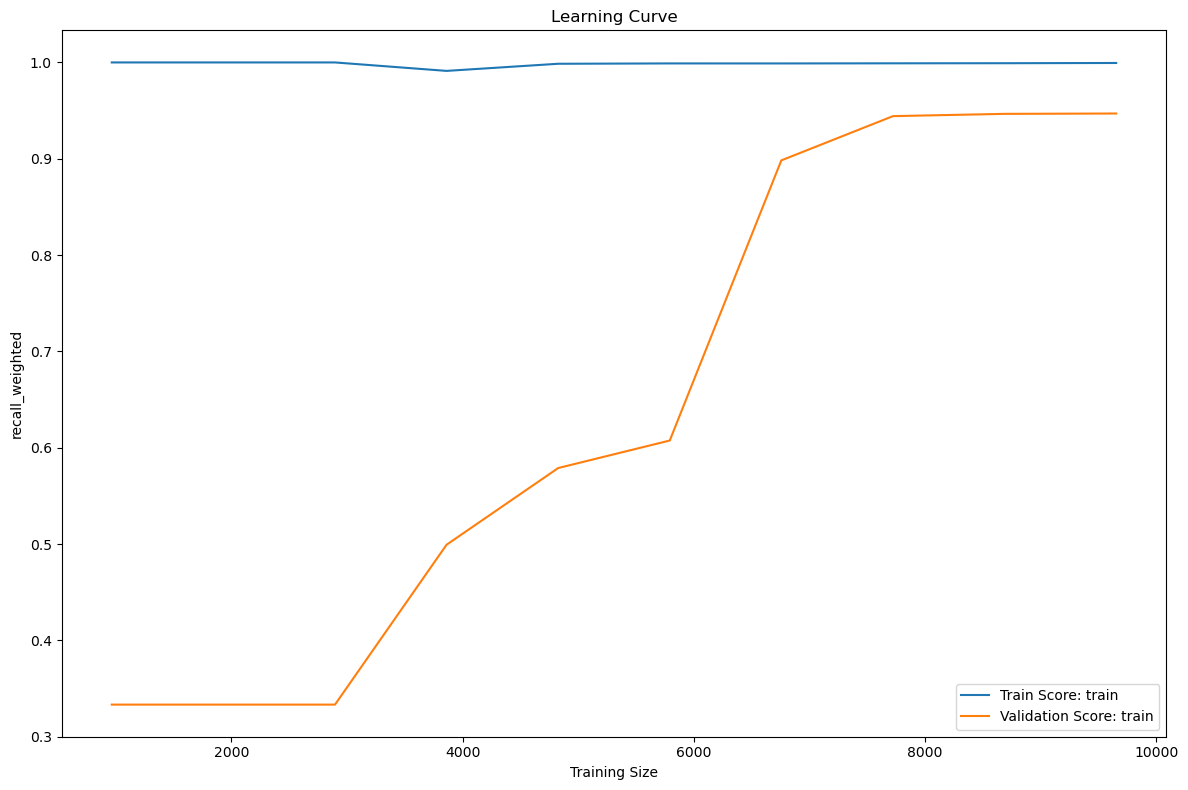

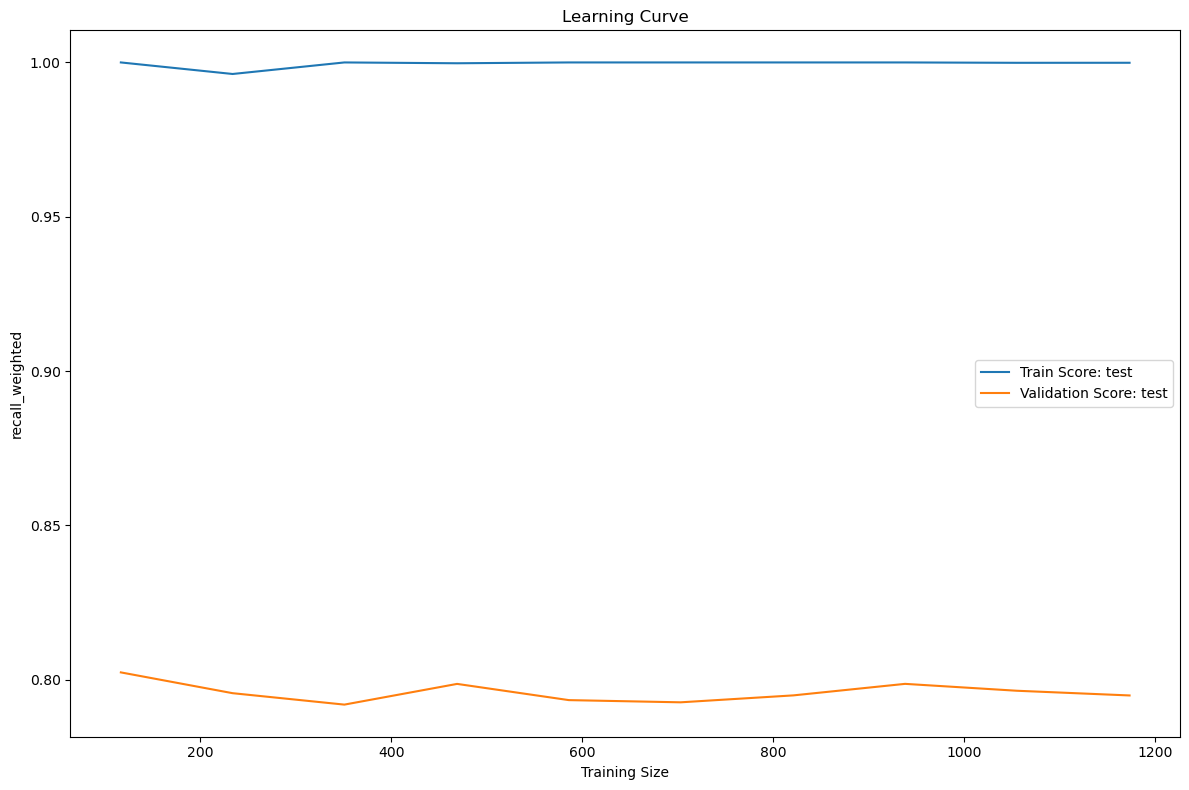

AdaBoost

Predictions on the training set...
...Done.
Predictions on the test set...
...Done.
Confusion Matrix and Classification Report for the Training Set:
[[2728  437  513]
 [ 665 2340  673]
 [ 756  558 2364]]
              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70      3678
         1.0       0.70      0.64      0.67      3678
         2.0       0.67      0.64      0.65      3678

    accuracy                           0.67     11034
   macro avg       0.68      0.67      0.67     11034
weighted avg       0.68      0.67      0.67     11034


Confusion Matrix and Classification Report for the Test Set:
[[683 114 123]
 [  7  23  17]
 [ 72  67 235]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       920
           1       0.11      0.49      0.18        47
           2       0.63      0.63      0.63       374

    accuracy                           0.70      1341
   macro avg       0.55  

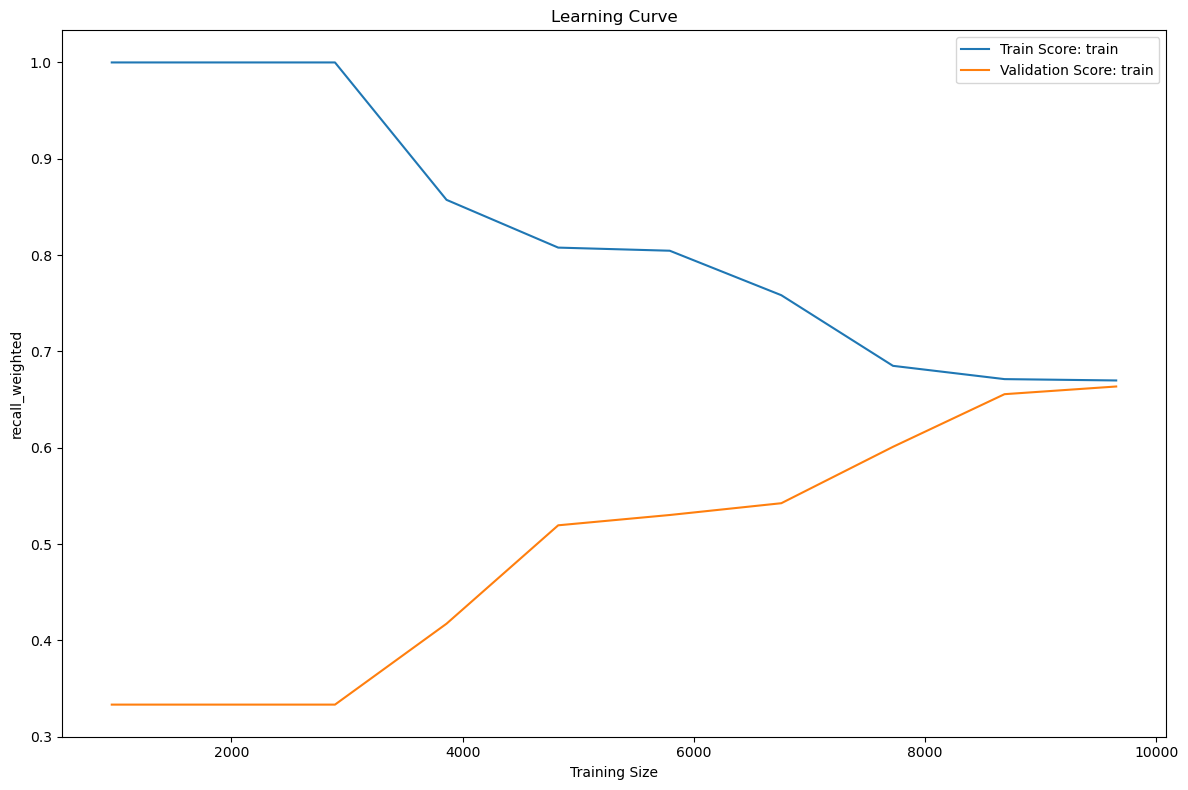

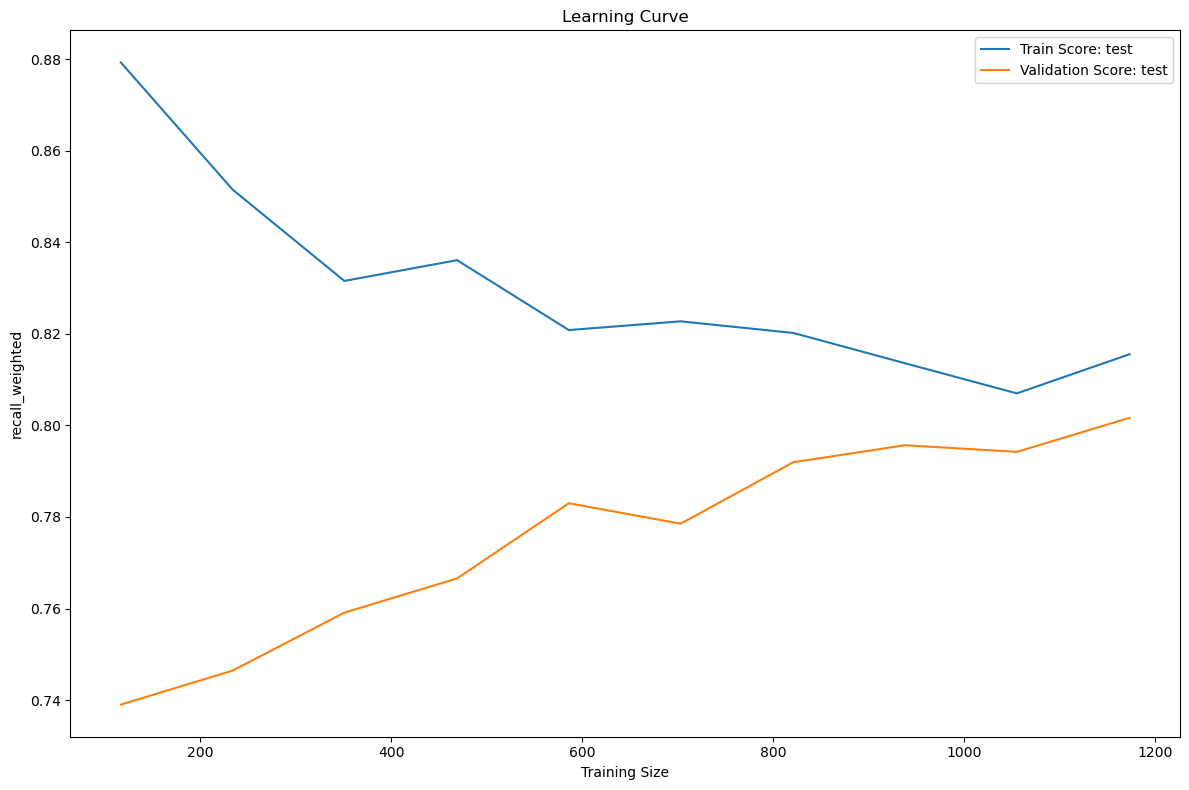

SVM

Predictions on the training set...
...Done.
Predictions on the test set...
...Done.
Confusion Matrix and Classification Report for the Training Set:
[[2863  422  393]
 [ 968 2447  263]
 [ 739  683 2256]]
              precision    recall  f1-score   support

         0.0       0.63      0.78      0.69      3678
         1.0       0.69      0.67      0.68      3678
         2.0       0.77      0.61      0.68      3678

    accuracy                           0.69     11034
   macro avg       0.70      0.69      0.69     11034
weighted avg       0.70      0.69      0.69     11034


Confusion Matrix and Classification Report for the Test Set:
[[706 113 101]
 [ 15  23   9]
 [ 79  69 226]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       920
           1       0.11      0.49      0.18        47
           2       0.67      0.60      0.64       374

    accuracy                           0.71      1341
   macro avg       0.56      0

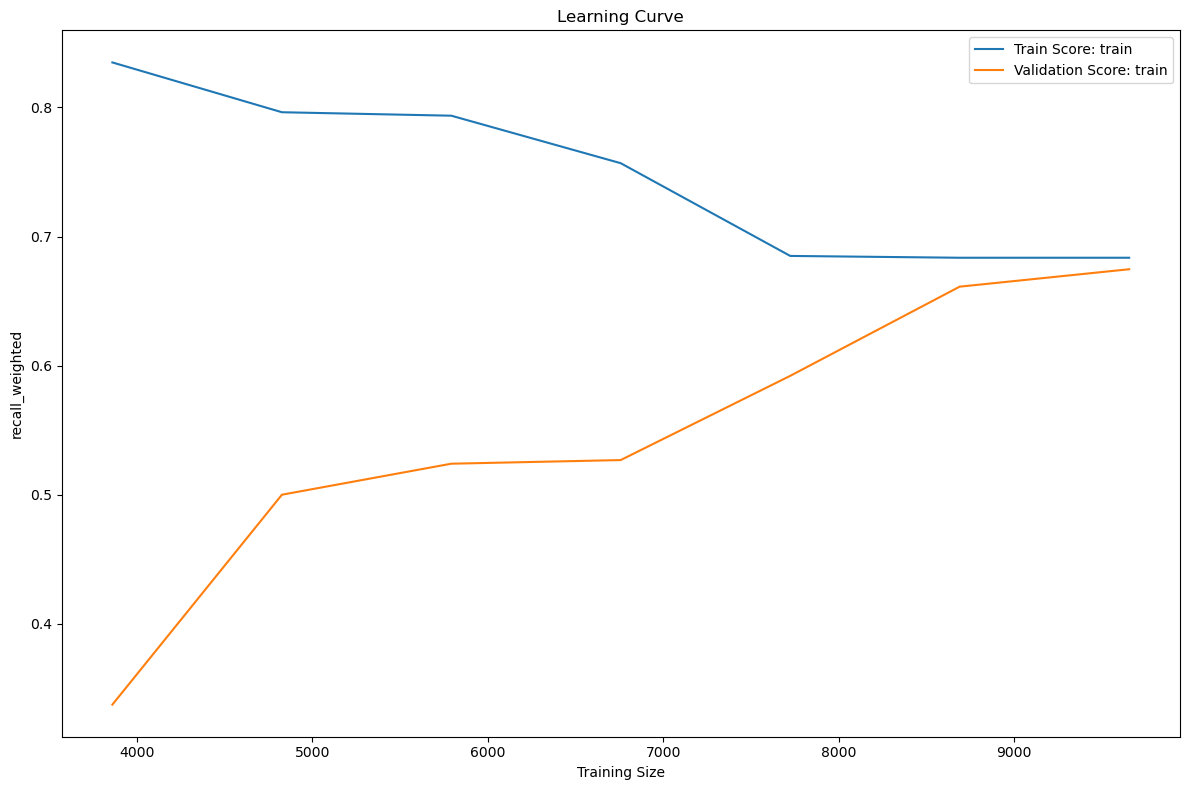

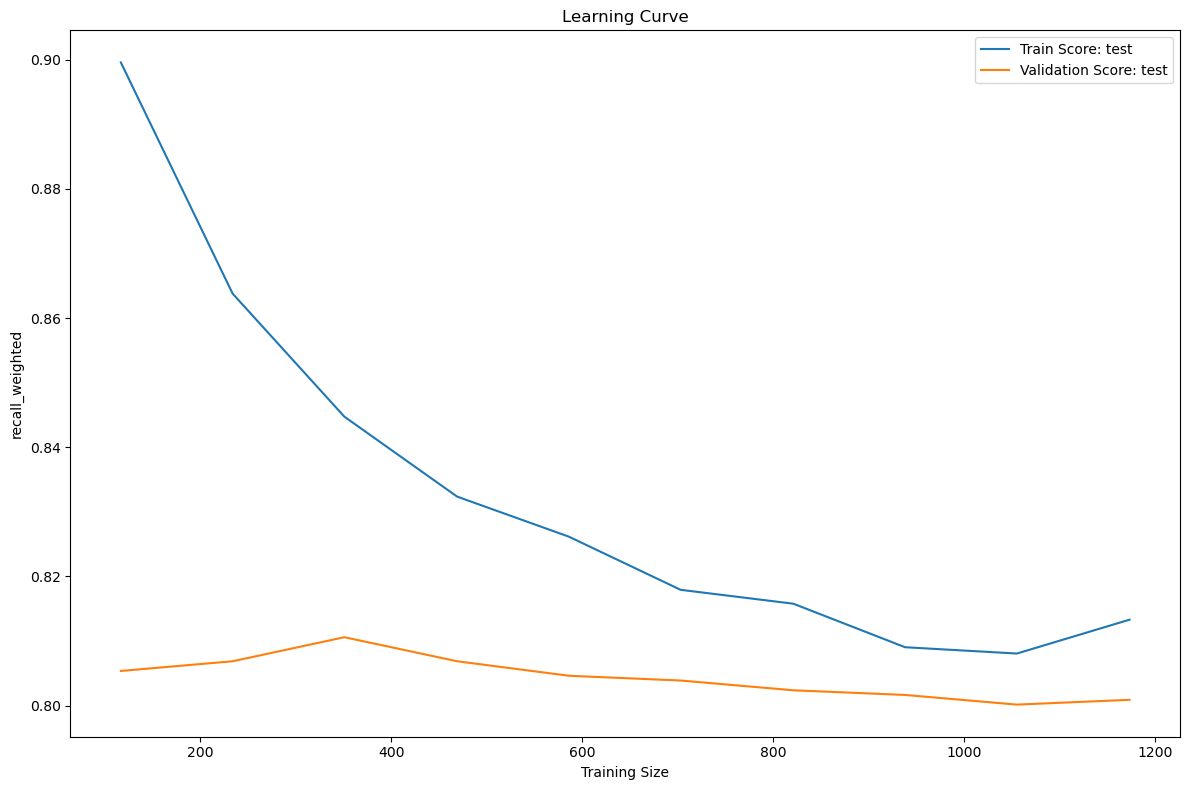

KNN

Predictions on the training set...
...Done.
Predictions on the test set...
...Done.
Confusion Matrix and Classification Report for the Training Set:
[[2919  174  585]
 [   0 3678    0]
 [ 197   54 3427]]
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86      3678
         1.0       0.94      1.00      0.97      3678
         2.0       0.85      0.93      0.89      3678

    accuracy                           0.91     11034
   macro avg       0.91      0.91      0.91     11034
weighted avg       0.91      0.91      0.91     11034


Confusion Matrix and Classification Report for the Test Set:
[[680  64 176]
 [ 18  13  16]
 [ 91  29 254]]
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       920
           1       0.12      0.28      0.17        47
           2       0.57      0.68      0.62       374

    accuracy                           0.71      1341
   macro avg       0.52      0

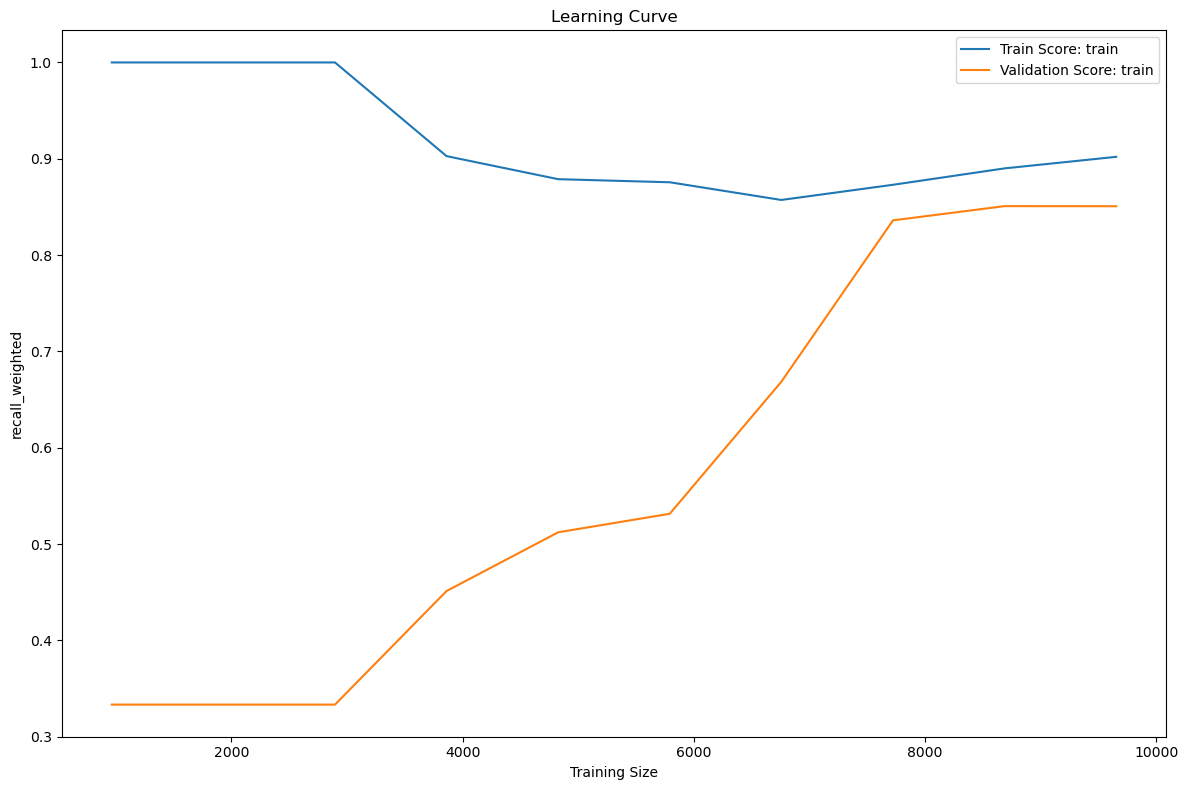

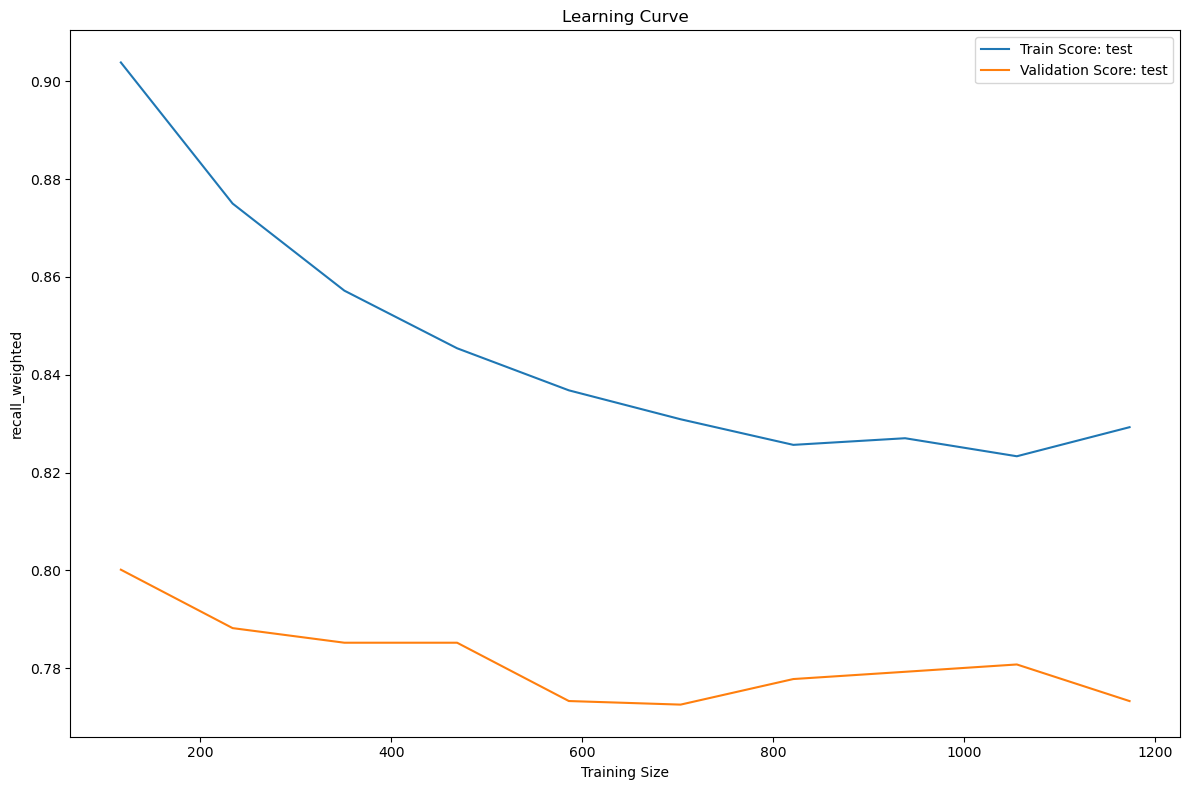

In [44]:
# Iterate over the dict_of_model to evaluate models with choosen characteristics
for name, model in dict_of_models.items():
    print(name)
    print()
    
    # Evaluate the model
    evaluation(model)
    
    # Plot the learning curve for the training set
    plot_learning_curve(model, X_train, Y_train, 8, scoring = 'recall_weighted', data = 'train' )
    
    # Plot the learning curve for the test set
    plot_learning_curve(model, X_test, Y_test, 8, scoring = 'recall_weighted', data ='test')

The Random Forest Classifier has the best result. Howewer we can notice Overfitting. We need to optimize this classifier

#### ***Weights***

In [45]:
# Access feature weights for RandomForest Pipeline
weights_RandomForest = RandomForest.named_steps['randomforestclassifier'].feature_importances_
weights_RandomForest

array([0.05610338, 0.09011111, 0.08252542, 0.14847775, 0.09556314,
       0.10730374, 0.0790569 , 0.08376914, 0.0754815 , 0.0657446 ,
       0.04837301, 0.06749031])

In [46]:
your_feature_names = df_train.columns
your_feature_names

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status'],
      dtype='object')

In [47]:
# Access feature names after preprocessing
selected_feature_indices = RandomForest.named_steps['pipeline']['selectkbest'].get_support(indices=True)

# Get the names of selected features after polynomial features
poly_feature_names = RandomForest.named_steps['pipeline']['polynomialfeatures'].get_feature_names_out(input_features=your_feature_names)

# Get the names of selected features
selected_feature_names = [poly_feature_names[i] for i in selected_feature_indices]

# Print the selected feature names
print("Selected Feature Names:", selected_feature_names)

# Access feature weights for RandomForest Pipeline
weights_RandomForest = RandomForest.named_steps['randomforestclassifier'].feature_importances_

# Map weights to selected feature names
feature_weight_mapping = dict(zip(selected_feature_names, weights_RandomForest))

# Print the feature weights
print("Feature Weights:", feature_weight_mapping)

Selected Feature Names: ['Age', 'Drug Age', 'Drug Hepatomegaly', 'Drug Albumin', 'Age Edema', 'Age Albumin', 'Age Copper', 'Hepatomegaly Edema', 'Hepatomegaly Albumin', 'Hepatomegaly Copper', 'Hepatomegaly Platelets', 'Edema Copper']
Feature Weights: {'Age': 0.056103375976216875, 'Drug Age': 0.09011111093389124, 'Drug Hepatomegaly': 0.08252541955251771, 'Drug Albumin': 0.14847775342394487, 'Age Edema': 0.09556313865343895, 'Age Albumin': 0.10730374200577836, 'Age Copper': 0.07905689721180298, 'Hepatomegaly Edema': 0.08376914108193478, 'Hepatomegaly Albumin': 0.07548150083563122, 'Hepatomegaly Copper': 0.06574460383504245, 'Hepatomegaly Platelets': 0.048373011042781744, 'Edema Copper': 0.0674903054470189}


the initial dataset had 19 features, the application of PolynomialFeatures with a degree of 2 created polynomial combinations of all the pairs of features, giving a total of (19 + 19 + 1) * 19 / 2 = 135 features (counting square terms and cross products).
which will be applied a selectkbest, hence the presence of columns with two headings.

In order to have a better vision of features importances. The SHAP method for tree algorithms can be used

In [48]:
import shap

# Explain RandomForest model predictions with SHAP
explainer = shap.TreeExplainer(RandomForest.named_steps['randomforestclassifier'])
shap_values = explainer.shap_values(X_train)

# Get the average SHAP value for each feature
average_shap_values = np.mean(np.abs(shap_values), axis=0)

# Create a mapping between feature names and their average SHAP values
shap_mapping = dict(zip(selected_feature_names, average_shap_values))

# Print the SHAP Values Mapping
print("SHAP Values Mapping:")
for feature, shap_value in shap_mapping.items():
    print(f"{feature}: {shap_value}")

SHAP Values Mapping:
Age: [0.01634004 0.01652955 0.01874146 0.07537705 0.02354065 0.03361386
 0.03426642 0.02413776 0.02072697 0.01031416 0.00825849 0.04407434
 0.         0.         0.         0.         0.         0.
 0.        ]
Drug Age: [0.0228597  0.02885211 0.02174443 0.07313159 0.02274522 0.0482995
 0.03988276 0.0218683  0.01717019 0.01115087 0.00794846 0.04354617
 0.         0.         0.         0.         0.         0.
 0.        ]
Drug Hepatomegaly: [0.02142274 0.01705431 0.01773966 0.06807993 0.02229529 0.04679826
 0.03585606 0.01897233 0.01602441 0.01382185 0.00812434 0.04478456
 0.         0.         0.         0.         0.         0.
 0.        ]
Drug Albumin: [0.01982112 0.01436915 0.02131698 0.06970651 0.03005709 0.00980554
 0.03406609 0.01903292 0.01626021 0.0078493  0.00916207 0.03975032
 0.         0.         0.         0.         0.         0.
 0.        ]
Age Edema: [0.02039259 0.01074318 0.01777156 0.07341512 0.02433708 0.04225728
 0.03957705 0.01710041 0.01439

In [77]:
# Calculate SHAP mean for each features
average_shap_values = {feature: np.mean(values) for feature, values in shap_mapping.items()}

# Display SHAP mean for each features
print("Moyenne des valeurs SHAP:")
for feature, average_shap in average_shap_values.items():
    print(f"{feature}: {average_shap}")

Moyenne des valeurs SHAP:
Age: 0.017153723481070055
Drug Age: 0.01890522576683842
Drug Hepatomegaly: 0.017419669865958772
Drug Albumin: 0.0153261733160636
Age Edema: 0.016784481996581405
Age Albumin: 0.0188063174758902
Age Copper: 0.01595777611659077
Hepatomegaly Edema: 0.018314562856660017
Hepatomegaly Albumin: 0.016831902809292774
Hepatomegaly Copper: 0.015585896769033705
Hepatomegaly Platelets: 0.017042074126900314
Edema Copper: 0.017946841068301637


The average of the SHAP values for each feature calculated indicates the average impact of each feature on your data set. More precisely, it represents the average contribution of each feature to the difference between the model's prediction and the average value of the predictions.

#### ***Optimization***

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
AdaBoost

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=12))])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [51]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=12))])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [52]:
KNN

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=12))])),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [53]:
RandomForest

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=12))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [54]:
# Grid of values to be tested
hyper_params = {
    'randomforestclassifier__max_depth': [24, 25, 26],
    'randomforestclassifier__min_samples_leaf': [1, 2],
    'randomforestclassifier__min_samples_split': [1.0, 2, 3],
    'randomforestclassifier__n_estimators': [105, 106, 107]}

In [55]:
RandomForest.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'randomforestclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__polynomialfeatures', 'pipeline__selectkbest', 'pipeline__polynomialfeatures__degree', 'pipeline__polynomialfeatures__include_bias', 'pipeline__polynomialfeatures__interaction_only', 'pipeline__polynomialfeatures__order', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__

In the context where our main objective is to minimise false negatives, i.e. not to miss the detection of people who are going to die (class D), we should focus on the recall metric Recall measures the model's ability to identify all positive examples.

In [56]:
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [57]:
# Define the metrics to evaluate
scoring_metrics = ['f1_weighted', 'recall_weighted']

"""
F1 Weighted Score ('f1_weighted'):

The F1 score is a metric that combines precision and recall into a single value. It's the harmonic mean of precision and recall.
The 'weighted' variant takes into account the imbalance in the class distribution by computing the average F1 score for each class, weighted by the number of instances of each class.
This is particularly useful when dealing with imbalanced datasets where some classes have much fewer instances than others. It provides a more comprehensive evaluation when there is a class imbalance.

Weighted Recall ('recall_weighted'):

Recall, also known as sensitivity or true positive rate, measures the ability of a classifier to identify all relevant instances.
The 'weighted' variant calculates the average recall for each class, weighted by the number of instances of each class.
Similar to 'f1_weighted', this is useful in the context of imbalanced datasets as it considers the impact of class distribution on the overall performance.

"""

"\nF1 Weighted Score ('f1_weighted'):\n\nThe F1 score is a metric that combines precision and recall into a single value. It's the harmonic mean of precision and recall.\nThe 'weighted' variant takes into account the imbalance in the class distribution by computing the average F1 score for each class, weighted by the number of instances of each class.\nThis is particularly useful when dealing with imbalanced datasets where some classes have much fewer instances than others. It provides a more comprehensive evaluation when there is a class imbalance.\n\nWeighted Recall ('recall_weighted'):\n\nRecall, also known as sensitivity or true positive rate, measures the ability of a classifier to identify all relevant instances.\nThe 'weighted' variant calculates the average recall for each class, weighted by the number of instances of each class.\nSimilar to 'f1_weighted', this is useful in the context of imbalanced datasets as it considers the impact of class distribution on the overall perfor

In [58]:
# If refit is set to True, it means that once the grid search is complete
# and the best parameters are identified, the model is automatically fitted to the entire training dataset with these best parameters.
# This can be convenient as it gives you a ready-to-use model with the best parameters,
# and you can directly use it to make predictions on new data without manually adjusting the model with the best parameters.

# Perform Grid Search with Cross-Validation
gridsearch = GridSearchCV(RandomForest, scoring=scoring_metrics, param_grid=hyper_params, cv=8, refit='recall_weighted', return_train_score=True, n_jobs=-1)
gridsearch.fit(X_train, Y_train)
print("Grid Search and Cross-Validation...Done.")

# Get the best model based on the grid search
best_model = gridsearch.best_estimator_

# Predictions on the training set
y_train_pred = best_model.predict(X_train)
# Predictions on the test set
y_test_pred = best_model.predict(X_test)

# Display evaluation metrics for the training set
print('Train:')
print(confusion_matrix(Y_train, y_train_pred))
print("Best hyperparameters: ", gridsearch.best_params_)
print("Best validation f1_weighted and recall_weighted scores compared to max(recall_weighted): ", gridsearch.best_score_)
print(classification_report(Y_train, y_train_pred))

print()

# Display evaluation metrics for the test set
print('Test:')
print(confusion_matrix(Y_test, y_test_pred))
print("Best hyperparameters: ", gridsearch.best_params_)
print(classification_report(Y_test, y_test_pred))

Grid Search and Cross-Validation...Done.
Train:
[[3672    1    5]
 [   0 3678    0]
 [   2    0 3676]]
Best hyperparameters:  {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 106}
Best validation f1_weighted and recall_weighted scores compared to max(recall_weighted):  0.9472545611711911
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3678
         1.0       1.00      1.00      1.00      3678
         2.0       1.00      1.00      1.00      3678

    accuracy                           1.00     11034
   macro avg       1.00      1.00      1.00     11034
weighted avg       1.00      1.00      1.00     11034


Test:
[[828   5  87]
 [ 22   6  19]
 [125   4 245]]
Best hyperparameters:  {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_

In [59]:
# Print scores
print("f1-score on training set : ", f1_score(Y_train, y_train_pred, average='weighted'))
print("f1-score on test set : ", f1_score(Y_test, y_test_pred, average='weighted'))
print()

print("recall on training set : ", recall_score(Y_train, y_train_pred, average='weighted'))
print("recall on test set : ", recall_score(Y_test, y_test_pred, average='weighted'))
print()

f1-score on training set :  0.9992749065169674
f1-score on test set :  0.7948079982979288

recall on training set :  0.9992749682798623
recall on test set :  0.8046234153616704



In [60]:
# Afficher le nombre de caractéristiques sélectionnées dans le meilleur modèle
num_features_selected = preprocessor_2.named_steps['selectkbest'].get_support().sum()
num_features_selected

12

# Train best model on all data and use it to make predictions on X_without_labels (Test.csv)
**Before making predictions on the file test.csv, let's train our model on ALL the data that was in train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [61]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch.fit(X,Y)
best_model = gridsearch.best_estimator_
print("...Done.")

...Done.


In [62]:
# Read data without labels
df_test_without_labels = pd.read_csv(r'C:\Users\33760\Desktop\concours_kaggle\playground-series-s3e26\test.csv')
print('Prediction set (without labels) :', df_test_without_labels.shape)

Prediction set (without labels) : (5271, 19)


In [63]:
df_test_without_labels.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


## ***Apply preprocessing on df_test***

In [64]:
# Read data without labels
X_without_labels = pd.read_csv(r'C:\Users\33760\Desktop\concours_kaggle\playground-series-s3e26\test.csv')
print('Prediction set (without labels) :', X_without_labels.shape)

Prediction set (without labels) : (5271, 19)


In [65]:
drop_column(X_without_labels, 'id', df_name = 'df_train')

The 'id' column has been removed from df_train.


In [66]:
# apply winsorising
X_without_labels = winsorize_outliers_dataframe(X_without_labels, lower_percentile=0.05, upper_percentile=0.95)

In [67]:
# Apply Separate_cat_num
numeric_features_X, categorical_features_X = separate_cat_num_variable(X_without_labels)

Found numeric features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Found categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [68]:
"""preprocessor = Create_pipeline_preprocessor(numeric_features_X, categorical_features_X)"""

'preprocessor = Create_pipeline_preprocessor(numeric_features_X, categorical_features_X)'

In [69]:
# Ajust and transform X_without_labels in a single step
X_without_labels_transformed_processed = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels_transformed_processed[0:5,:])

...Done
[[3.8390e+03 1.9724e+04 1.2000e+00 5.4600e+02 3.3700e+00 6.5000e+01
  1.6360e+03 1.5190e+02 9.0000e+01 4.3000e+02 1.0600e+01 2.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [2.4680e+03 1.4975e+04 1.1000e+00 6.5200e+02 4.0900e+00 9.4000e+01
  1.2570e+03 1.5190e+02 1.5500e+02 2.2700e+02 1.0000e+01 2.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [3.3400e+02 1.3149e+04 2.0000e+00 2.0100e+02 2.9600e+00 4.6000e+01
  9.6100e+02 6.9750e+01 1.0100e+02 2.1300e+02 1.2050e+01 4.0000e+00
  1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00]
 [2.3300e+03 2.0510e+04 6.0000e-01 2.9300e+02 3.8500e+00 4.0000e+01
  6.1400e+02 1.2555e+02 5.6000e+01 2.7000e+02 1.0600e+01 2.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [1.6150e+03 2.1904e+04 1.4000e+00 2.7700e+02 2.9700e+00 1.2100e+02
  1.1100e+03 1.2500e+02 1.2600e+02 2.2100e+02 9.8000

In [70]:
preprocessor_2

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('selectkbest', SelectKBest(k=12))])

In [71]:
# Apply polynomial augmentation to X_without_labels
X_without_labels_poly = preprocessor_2.named_steps['polynomialfeatures'].transform(X_without_labels_transformed_processed)

# Apply best features selection
X_without_labels_poly_selected = preprocessor_2.named_steps['selectkbest'].transform(X_without_labels_poly)

In [72]:
# Predict class probabilities for each instance in the feature data
proba_predictions = best_model.predict_proba(X_without_labels_transformed_processed)
proba_predictions

array([[0.77570093, 0.00934579, 0.21495327],
       [0.62616822, 0.28037383, 0.09345794],
       [0.58878505, 0.06542056, 0.34579439],
       ...,
       [0.86915888, 0.04672897, 0.08411215],
       [0.98130841, 0.        , 0.01869159],
       [0.24299065, 0.05607477, 0.70093458]])

In [73]:
# Create a DataFrame with the predicted probabilities
df_predictions = pd.DataFrame(proba_predictions)

# Rename the columns according to your preferences
df_predictions = df_predictions.rename(columns={
    0: 'Status_C',
    1: 'Status_CL',
    2: 'Status_D'
    # Add other mappings if necessary
})

# Display the DataFrame
df_predictions.head()

,Status_C,Status_CL,Status_D
0,0.775701,0.009346,0.214953
1,0.626168,0.280374,0.093458
2,0.588785,0.065421,0.345794
3,0.948598,0.037383,0.014019
4,0.766355,0.037383,0.196262


In [74]:
# Concatenate the 'id' column to the left of the df_predictions DataFrame
df_result = pd.concat([df_test_copy['id'], df_predictions], axis=1)

# Display the resulting DataFrame
df_result.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.775701,0.009346,0.214953
1,7906,0.626168,0.280374,0.093458
2,7907,0.588785,0.065421,0.345794
3,7908,0.948598,0.037383,0.014019
4,7909,0.766355,0.037383,0.196262


In [75]:
df_result.to_csv(r'C:\Users\33760\Desktop\concours_kaggle\predictions.csv', index = False)